# Stationarity and Autocorrelation

Before we learn another forecasting technique we have a brief aside on stationarity and autocorrelation.

## What we will accomplish

In this notebook we will:
- Define the concepts of:
    - Strict stationarity and
    - Weak stationarity,
- Learn about autocorrelation,
- Plot autocorrelation at different lags and
- Learn about differencing.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
set_style("whitegrid")

## Stationarity

<i>Stationarity</i> is a statistical property of a time series that can be needed for a forecasting method to work.

We say that a time series $\left\lbrace y_t  \right\rbrace$ is <i>strictly stationary</i> if the joint probability distribution of $y_{t_1}, y_{t_2}, \dots y_{t_n}$ is equal to that of $y_{t_1 + \tau}, y_{t_2 + \tau}, \dots y_{t_n + \tau}$. for any $t_1, \dots, t_n, \tau, n$. This implies that the joint distribution only depends on the intervals between $t_1, \dots, t_n$ and in particular if $n=1$:

$$
E(y_t) =  \mu, \ \ \ \text{Var}(y_t) = \sigma^2
$$

are not functions of $t$. Further if $n=2$ the joint distribution of $y_{t_1}$ and $y_{t_2}$ only depends on $(t_2 - t_1)$, which is called the <i>lag</i> between $t_1$ and $t_2$.

Strict stationarity is quite restrictive and we more often define a weaker sense of <i>stationarity</i>.

We will say that a time series is <i>stationary</i> if:

$$
E(y_t) = \mu, \ \text{ and } \ \text{Cov}\left( y_t, y_{t+\tau} \right) = \gamma(\tau).
$$

### Examples

Some examples of a stationary time series are:
- White noise, 
- The first differences of a random walk, i.e. 

$$
y_{t+1} - y_t \text{ if } y_{t+1} = y_t + \epsilon \text{ for all } t \text{ and}
$$

- A moving average process, i.e. 

$$
y_{t} = \beta_0 \epsilon_{t} + \beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + \dots + \beta_q \epsilon_{t-q}.
$$

In the next forecasting approach we will learn it is important for the time series data to be stationary. One way to visually gauge if that is true is by plotting the autocorrelation.

## Autocorrelation

The <i>autocorrelation</i> of a time series is essentially the correlation of that time series with its future observations placed at different lags. In particular, the autocorrelation of a time series at lag $k$ is given by:

$$
\begin{align*}
r_k &= 
\operatorname{Corr}(y_{t+k},y_t)\\
&=\frac{\operatorname{Cov}(y_{t+k},y_{t})}{\operatorname{StDev}(y_{t+k})\operatorname{StDev}(y_{t})} \\
\end{align*}
$$

If the time series is stationary, then $\operatorname{StDev}(y_{t+k}) = \operatorname{StDev}(y_{t})$, so their product is just the variance $\operatorname{Var}(y_t)$.  In this case we can use

$$
r_k = \frac{\displaystyle\sum_{t=1}^{n-k} \left(y_t - \overline{y}\right) \left(y_{t+k} - \overline{y} \right)}{\displaystyle\sum_{t=1}^n \left(y_t - \overline{y}\right)^2}
$$

as the sample statistic where $n$ is the last observation of the time series.

### Correlogram

We commonly plot this as a way to visually probe if our data series clearly violates stationarity. This can be done with `statsmodels` `plot_acf` function, <a href="https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html</a>.

#### Example: White noise

In [9]:
import statsmodels.api as sm

In [10]:
## make some data
## white noise
np.random.seed(440)
series = np.random.random(100) - .5

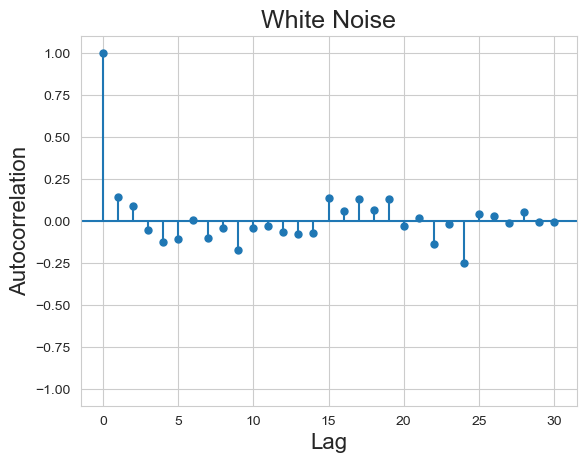

In [11]:
## first put in the time series
## then set how many lags you want to consider
## the default is lags=30
## we will turn alpha=None
## this turns off the confidence interval lines, which we will not discuss
sm.graphics.tsa.plot_acf(series,
                            alpha = None,
                            lags = 30)

plt.title('White Noise', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

The autocorrelation of every time series will be $1$ at lag $0$. For stationary series, like white noise, we excpect to seem some low autocorrelation for small lags. Autocorrelation should then tend to randomly bubble around getting closer and closer to $0$ as the lag increases.

#### Example: Data with a trend

If your data exhibits a trend it is <b>not</b> stationary. Here is an example of what the associated correlogram may look like for data with a trend.

In [12]:
goog = pd.read_csv("../../data/google_stock.csv", parse_dates=['date'])

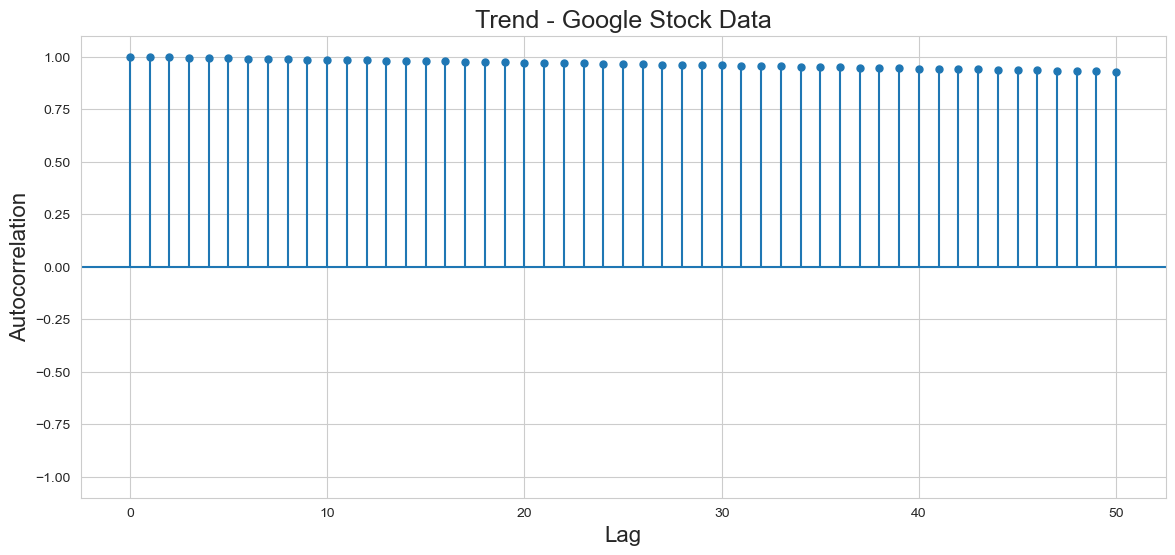

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

sm.graphics.tsa.plot_acf(goog.closing_price.values,
                            alpha=None,
                            lags = 50,
                            ax = ax)

plt.title('Trend - Google Stock Data', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

If you see a correlogram that has high (in magnitude) autocorrelation values over a long range of lags this is indicative of a time series that is not stationary. Importantly, seing a time series with a correlogram like this does not necessarily imply that the time series in question exhibits a trend, just that it is not stationary.

<i>We will see how we may turn this into a stationary series below</i>.

#### Example: Data with seasonality

If your data exhibits seasonality it is <b>not</b> stationary. Here is an example that demonstrates what a seasonal correlogram may look like.

In [14]:
flu = pd.read_csv("../../data/us_flu_1928_1948.csv", parse_dates=['date'])

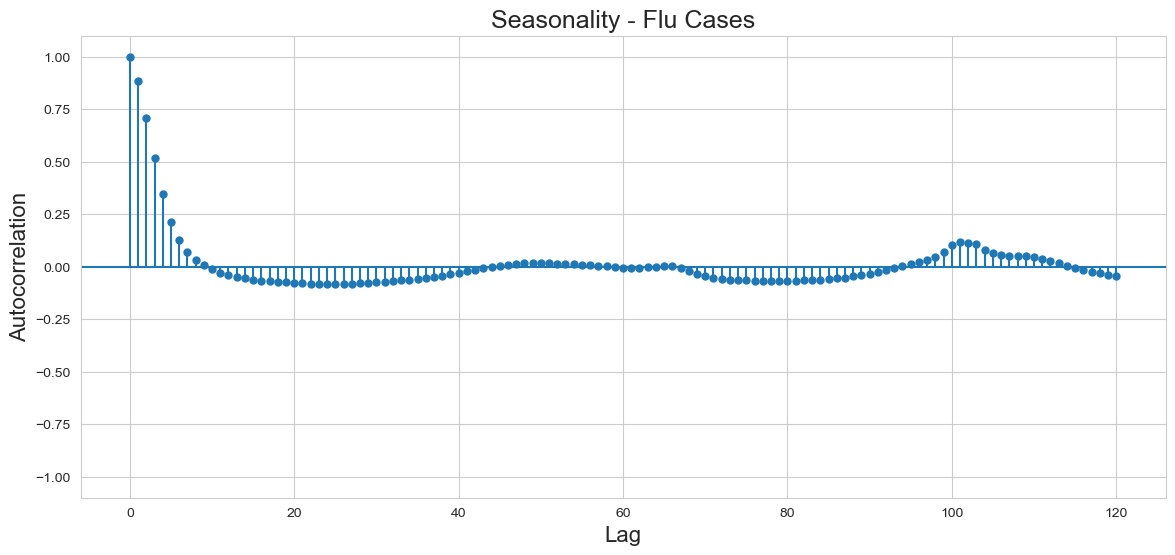

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

sm.graphics.tsa.plot_acf(flu.cases,
                            alpha=None,
                            lags=120,
                            ax=ax)

plt.title('Seasonality - Flu Cases', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

Time series with seasonality often produce sinusoidal autocorrelation plots. Similar to our above point, seeing sinusoidal autocorrelation may hint at seasonality but is not always proof that a time series exhibits seasonality. However, it does imply that the time series is probably not stationary.

<i>There are also techniques for producing a stationary time series out of a seasonal one, but we leave that for the corresponding `Practice Problems` notebook.</i>

### Statistical tests

There are formal statistical tests that you can perform to examine if a time series whether a time series is stationary, but we will not cover them. Interested parties may wish to start here:
- <a href="https://en.wikipedia.org/wiki/Unit_root_test">https://en.wikipedia.org/wiki/Unit_root_test</a> and
- <a href="https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test">https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test</a>.

## Differencing

At times we may wish to apply a forecasting method that requires a stationary time series. It is often possible to produce a stationary series from a non-stationary one with <i>differencing</i>. We will demonstrate this process for data without seasonality, the approach for data with seasonality is left for the `Practice Problems` notebook.

Differencing refers to subtracting the previous observation from the current. For example, the first differences of a time series $\left\lbrace y_t \right\rbrace$ are:

$$
\nabla y_2 = y_2 - y_1, \nabla y_3 = y_3 - y_2, \nabla y_4 = y_4 - y_3, \dots \nabla y_t = y_t - y_{t-1}.
$$

The series $\left\lbrace \nabla y_t \right\rbrace$ now begins indexing at $2$ and is $1$ observation smaller than the original series. In some sense we can think of the first differences as analagous to the first derivative of a function.

#### In python

We can perform differencing quickly with a the `.diff()` function in `pandas`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html</a>.

For non-seasonal data a single difference is typically sufficient to produce a stationary time series.

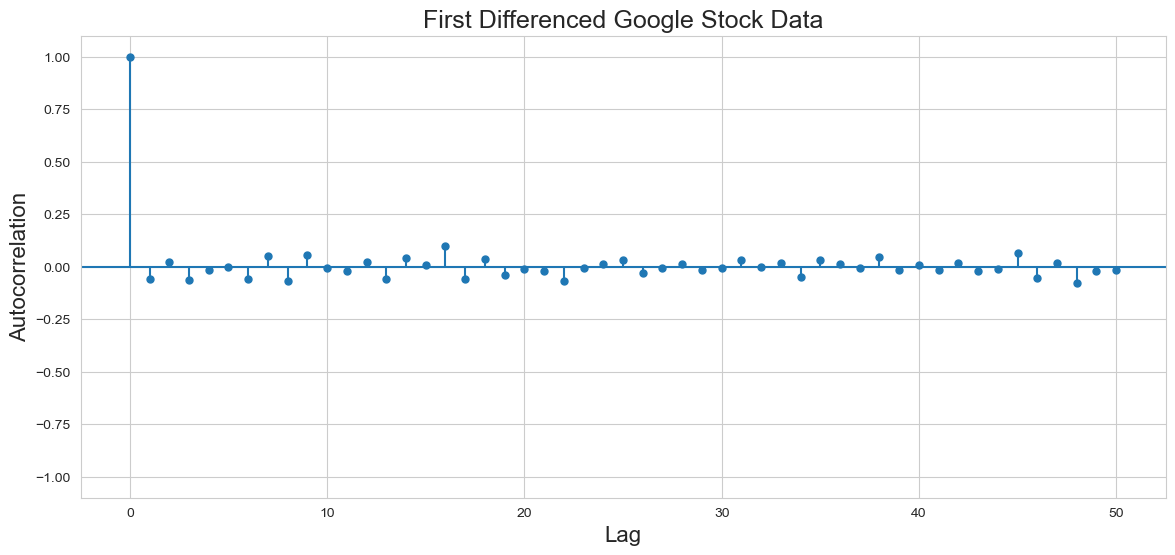

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

## use pandas .diff()
sm.graphics.tsa.plot_acf(goog.closing_price.diff()[1:],
                            alpha=None,
                            ax=ax,
                            lags=50)

plt.title('First Differenced Google Stock Data', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

Sometimes you may need to perform differencing more than once. You perform additional differencing to the series that resulted from the previous differencing step. For example:

$$
\nabla ^2 y_t = \nabla \nabla y_t = \nabla y_t - \nabla y_{t-1} =  \left(y_t - y_{t-1}\right) - \left(y_{t-1} - y_{t-2}\right) = y_t - 2y_{t-1} + y_{t-2}.
$$

Applying further differencing is similar.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)